In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image

In [10]:
# مسیر به پوشه تصاویر و فایل JSON
data_dir = 'dataset/'           # مسیر پوشه تصاویر
ann_file = 'dataset/annotations/instances_Train.json'   # مسیر فایل JSON
output_dir = 'dataset/train_new'  # مسیر پوشه ذخیره‌سازی تصاویر برش‌خورده


In [4]:
# تنظیمات پیش‌پردازش شامل تغییر اندازه و نرمال‌سازی
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه به 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Pre Train

In [5]:
# بارگذاری داده‌ها با فرمت COCO
coco_dataset = CocoDetection(root=data_dir, annFile=ann_file, transform=transform)

# ایجاد DataLoader برای مدیریت داده‌ها
data_loader = DataLoader(coco_dataset, batch_size=32, shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Data Augmentation

In [6]:
# افزودن تغییرات تصادفی به تصاویر برای افزایش داده‌ها
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Test Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.5702832].


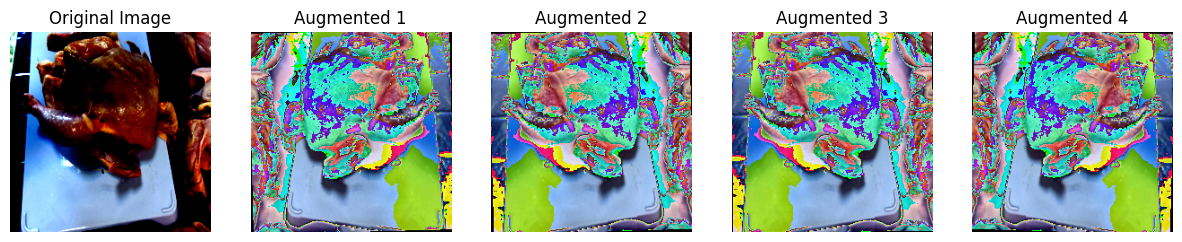

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

# تنظیم Augmentation ساده و طبیعی
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(3),  # چرخش بسیار محدود به 3 درجه
    transforms.Resize((224, 224))  # تغییر اندازه به 224x224 بدون برش
])

# تعداد نمونه‌های مورد نظر برای نمایش (یک تصویر اصلی و بقیه Augmented)
num_samples = 5

# انتخاب یک تصویر تصادفی از دیتاست
image, _ = coco_dataset[random.randint(0, len(coco_dataset) - 1)]

# نمایش تصویر اصلی و نمونه‌های Augmented
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# نمایش تصویر اصلی در اولین ستون
axes[0].imshow(image.permute(1, 2, 0))
axes[0].set_title("Original Image")
axes[0].axis('off')

# نمایش تصاویر Augmented در ستون‌های بعدی
for i in range(1, num_samples):
    pil_image = transforms.ToPILImage()(image)
    augmented_image = augmentation_transform(pil_image)  # اعمال Augmentation روی PIL Image

    # تبدیل تصویر Augmented به Tensor و نمایش
    augmented_image = transforms.ToTensor()(augmented_image)
    axes[i].imshow(augmented_image.permute(1, 2, 0))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.show()


In [11]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader

# تنظیمات اولیه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.0003

# تنظیمات پیش‌پردازش شامل تغییر اندازه ثابت
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه ثابت به 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

coco_dataset.transform = transform

# تعریف collate_fn برای یکنواخت‌سازی ابعاد تصاویر
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [transform(Image.fromarray(img.numpy().transpose(1, 2, 0))) if isinstance(img, torch.Tensor) else transform(img) for img in images]
    images = torch.stack(images)  # تبدیل لیست تصاویر به Tensor
    return images, targets

# تقسیم داده‌ها به آموزشی و تست
train_size = int(0.8 * len(coco_dataset))
test_size = len(coco_dataset) - train_size
train_dataset, test_dataset = random_split(coco_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# بارگذاری و تنظیم مدل InceptionV3
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # تنظیم خروجی برای دو کلاس
model = model.to(device)

# تنظیمات آموزش
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# آموزش مدل
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = images.to(device)
        targets = torch.tensor([t['category_id'] for t in targets]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# ذخیره مدل
torch.save(model.state_dict(), "chicken_freshness_model.pth")

# تابع پیش‌بینی
def predict_image(model, image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    classes = ["Fresh", "Deforest"]
    result = classes[predicted.item()]
    print(f"The model predicts this image as: {result}")
    return result

# تست پیش‌بینی
image_path = 'dataset/test/deforest/IMG_4105.jpg'
predict_image(model, image_path)


TypeError: Cannot handle this data type: (1, 1, 3), <f4

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


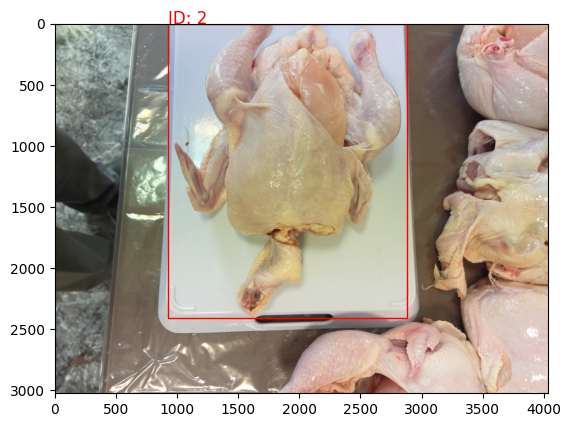

In [5]:
# ایجاد dataset با استفاده از فرمت COCO
coco_dataset = CocoDetection(root=data_dir, annFile=ann_file, transform=transforms.ToTensor())

# انتخاب یکی از تصاویر و برچسب‌های آن
image, targets = coco_dataset[0]  # می‌توانید اندیس را تغییر دهید

# تبدیل تصویر به فرمت قابل نمایش
image = image.permute(1, 2, 0).numpy()  # تغییر ترتیب ابعاد برای نمایش با matplotlib

# رسم تصویر
fig, ax = plt.subplots(1)
ax.imshow(image)

# رسم باندینگ‌باکس‌ها و برچسب‌ها
for target in targets:
    bbox = target['bbox']  # باندینگ‌باکس در قالب [x, y, width, height]
    category_id = target['category_id']
    
    # رسم باندینگ‌باکس
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # نمایش نام برچسب (category)
    plt.text(bbox[0], bbox[1], f"ID: {category_id}", color='red', fontsize=12)

plt.show()


In [10]:

# اطمینان از ایجاد پوشه خروجی
os.makedirs(output_dir, exist_ok=True)

# بارگذاری دیتاست با فرمت COCO
coco_dataset = CocoDetection(root=data_dir, annFile=ann_file, transform=transforms.ToTensor())

# برش باندینگ‌باکس‌ها و ذخیره تصاویر
for i in range(len(coco_dataset)):
    image, targets = coco_dataset[i]  # دسترسی به تصویر و برچسب‌ها
    image_pil = transforms.ToPILImage()(image)  # تبدیل Tensor به PIL Image

    for j, target in enumerate(targets):
        bbox = target['bbox']  # باندینگ‌باکس در قالب [x, y, width, height]
        category_id = target['category_id']

        # محاسبه مختصات باندینگ‌باکس
        x, y, width, height = map(int, bbox)
        cropped_image = image_pil.crop((x, y, x + width, y + height))

        # ذخیره تصویر برش‌خورده با نام منحصر به فرد
        output_path = os.path.join(output_dir, f"image_{i}_bbox_{j}_class_{category_id}.jpg")
        cropped_image.save(output_path)

        print(f"Saved cropped image: {output_path}")

print("All images cropped and saved successfully.")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Saved cropped image: dataset/train_new/image_0_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_1_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_2_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_3_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_4_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_5_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_6_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_7_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_8_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_9_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_10_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_11_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_12_bbox_0_class_2.jpg
Saved cropped image: dataset/train_new/image_13_bbox_0_c

In [11]:
import json

# مسیر فایل JSON خروجی از CVAT
json_path = 'dataset/annotations/instances_Train.json'   # مسیر فایل JSON


# بارگذاری فایل JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# نمایش نوع (برچسب) هر تصویر
for image_info in data['images']:
    image_id = image_info['id']
    image_name = image_info['file_name']
    
    # یافتن برچسب‌های مرتبط با این تصویر
    labels = []
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id:
            category_id = annotation['category_id']
            labels.append(data['categories'][category_id - 1]['name'])  # فرض بر اینکه ID دسته از 1 شروع می‌شود

    # نمایش نام و برچسب‌های تصویر
    print(f"Image: {image_name}, Labels: {set(labels)}")


Image: train/deforest/IMG_4088.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4089.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4090.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4091.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4092.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4093.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4094.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4095.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4096.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4097.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4098.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4099.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4100.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4101.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4102.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4103.jpg, Labels: {'deforest'}
Image: train/deforest/IMG_4104.jpg, Labels: {'deforest'}
Image: train/fresh/IMG_2029.JPG

In [4]:
import json
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from pathlib import Path

# مسیر داده‌ها و فایل JSON
data_dir = Path('dataset')  # مسیر تصاویر
json_path = 'dataset/annotations/instances_Train.json'  # مسیر فایل JSON

# تنظیمات پیش‌پردازش
# تنظیمات پیش‌پردازش با اندازه مناسب برای InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # تغییر اندازه به 299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# بارگذاری برچسب‌ها از فایل JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# ایجاد دیتاست
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, data, data_dir, transform):
        self.data = data
        self.data_dir = data_dir
        self.transform = transform
        self.image_annotations = {img['id']: img['file_name'] for img in data['images']}
        self.annotations = {ann['image_id']: ann['category_id'] for ann in data['annotations']}
        self.categories = {cat['id']: cat['name'] for cat in data['categories']}

    def __len__(self):
        return len(self.image_annotations)

    def __getitem__(self, idx):
        image_id = list(self.image_annotations.keys())[idx]
        img_path = self.data_dir / self.image_annotations[image_id]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        label_id = self.annotations[image_id]
        label = 0 if self.categories[label_id] == "Fresh" else 1  # "Fresh"=0, "Spoiled"=1

        return image, label

# ساخت دیتاست سفارشی
coco_dataset = CustomCocoDataset(data, data_dir, transform)

# تقسیم داده‌ها به آموزشی و تست
train_size = int(0.8 * len(coco_dataset))
test_size = len(coco_dataset) - train_size
train_dataset, test_dataset = random_split(coco_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.inception_v3(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # تنظیم برای دو کلاس
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# آموزش مدل
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        # جدا کردن خروجی اصلی از خروجی کمکی
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # انتخاب خروجی اصلی

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


# ذخیره مدل آموزش‌دیده
torch.save(model.state_dict(), "chicken_freshness_model.pth")


/Users/realxoman/Programming/PoultryInspector/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/realxoman/Programming/PoultryInspector/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Loss: 0.7110409140586853
Epoch 2/30, Loss: 0.23819833993911743
Epoch 3/30, Loss: 0.06629278510808945
Epoch 4/30, Loss: 0.027608783915638924
Epoch 5/30, Loss: 0.011363026686012745
Epoch 6/30, Loss: 0.005062017124146223
Epoch 7/30, Loss: 0.002467172220349312
Epoch 8/30, Loss: 0.002081808866932988
Epoch 9/30, Loss: 0.001188207301311195
Epoch 10/30, Loss: 0.0008973363437689841
Epoch 11/30, Loss: 0.0005778402555733919
Epoch 12/30, Loss: 0.0004399715398903936
Epoch 13/30, Loss: 0.0004389739769976586
Epoch 14/30, Loss: 0.00030817504739388824
Epoch 15/30, Loss: 0.000276287755696103
Epoch 16/30, Loss: 0.0002548334014136344
Epoch 17/30, Loss: 0.00022011954570189118
Epoch 18/30, Loss: 0.00019444955978542566
Epoch 19/30, Loss: 0.00015440933930221945
Epoch 20/30, Loss: 0.00016268690524157137
Epoch 21/30, Loss: 0.000129955486045219
Epoch 22/30, Loss: 0.00014805990213062614
Epoch 23/30, Loss: 0.00012897068518213928
Epoch 24/30, Loss: 0.00010492090223124251
Epoch 25/30, Loss: 8.88844006112

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.inception_v3(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # تنظیم برای دو کلاس
model = model.to(device)

In [38]:
# بارگذاری مدل آموزش‌دیده
model.load_state_dict(torch.load("chicken_freshness_model.pth"))
model.eval()

/var/folders/f4/r3y2j6q96953nvzh8x8msn280000gn/T/ipykernel_2301/3669510264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("chicken_fres

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [39]:
# ارزیابی مدل
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test/class_1/2024-11-27 11.45.42.jpg'

In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# تعریف ترانسفورمیشن‌ها برای داده‌های تست
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# تعریف دیتاست تست
data_dir = Path('dataset/test')  # مسیر تصاویر
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# ساخت DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


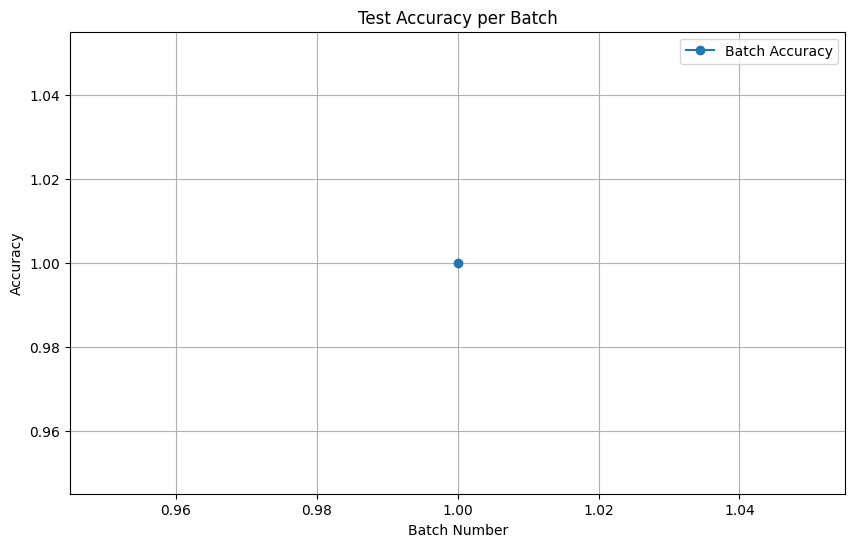

In [35]:
batch_accuracies = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        if isinstance(outputs, tuple):  # Check for auxiliary output in inception
            outputs = outputs[0]
        
        predictions = torch.argmax(outputs, dim=1)
        batch_accuracy = accuracy_score(labels.cpu(), predictions.cpu())
        batch_accuracies.append(batch_accuracy)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(batch_accuracies) + 1), batch_accuracies, marker='o', linestyle='-', label="Batch Accuracy")
plt.title("Test Accuracy per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [32]:


def predict_image(model, image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    classes = ["Fresh", "Deforest"]
    result = classes[predicted.item()]
    print(f"The model predicts this image as: {result}")
    return result



# تست پیش‌بینی
image_path = 'dataset/test/class_2/chert.jpg'
predict_image(model, image_path)


The model predicts this image as: Deforest


'Deforest'

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# تابع ارزیابی معیارهای مختلف روی مجموعه اعتبارسنجی
def evaluate_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # محاسبه معیارها
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return accuracy, precision, recall, f1


# حلقه آموزش همراه با ارزیابی روی مجموعه اعتبارسنجی
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # محاسبه معیارها روی مجموعه اعتبارسنجی
    accuracy, precision, recall, f1 = evaluate_metrics(model, train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, "
          f"Validation Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# معیارهای نهایی روی مجموعه اعتبارسنجی
final_accuracy, final_precision, final_recall, final_f1 = evaluate_metrics(model, train_loader)
print(f"Final Validation Metrics - Accuracy: {final_accuracy:.2f}, Precision: {final_precision:.2f}, "
      f"Recall: {final_recall:.2f}, F1 Score: {final_f1:.2f}")

TypeError: Cannot handle this data type: (1, 1, 3), <f4